In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor, Compose, CenterCrop
from matplotlib.lines import Line2D

from datasets import Embedding_Dataset
from utils import SamplePoint, is_valid_file

target_transform = Compose([
    SamplePoint(),
])
transform = Compose([
    ToTensor()
])
def custom_collate(batch):
    images, targets, embeddings = zip(*batch)
    masks, points = zip(*targets)
    return images, masks, points, embeddings

folder_path = '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/Liebherr/dataset'
dataset = Embedding_Dataset(root=folder_path, transform=transform, target_transform=target_transform, is_valid_file=is_valid_file)
dataloader = DataLoader(dataset, collate_fn=custom_collate, batch_size=8, shuffle=True)

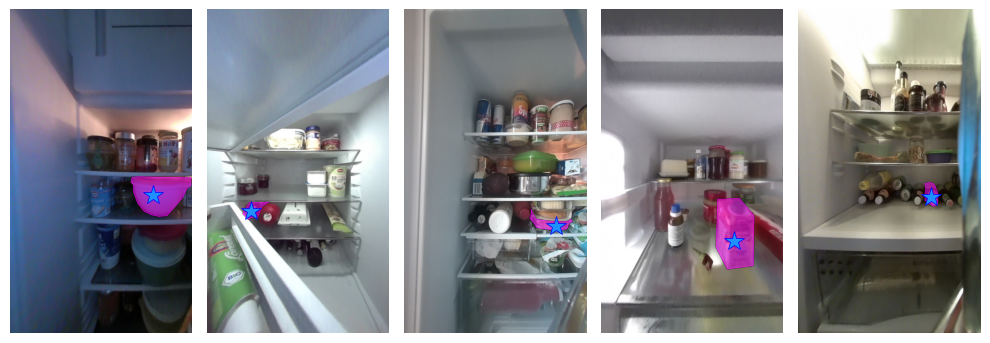

In [2]:
# Calculate the number of rows and columns based on the number of data loaders
num_cols = 5  # Number of images you want to display for each data loader

# Create a figure and axis with the calculated layout
fig, axes = plt.subplots(1, num_cols, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

# Plot example images and masks in each cell
for col_idx in range(num_cols):
    ax = axes[col_idx]
    batch = next(iter(dataloader))
    images, masks, points, embeddings = batch  # Assuming you have these variables in the batch

    # Plot the image
    ax.imshow(images[col_idx].permute(1, 2, 0))

    # Draw the mask on top of the image
    color = [255, 0, 255]
    mask_gray = np.asarray(masks[col_idx].permute(1, 2, 0) * 255).astype(np.uint8)
    mask_rgb = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGRA)
    mask_rgb[np.where((mask_rgb==[255, 255, 255, 255]).all(axis=2))] = color + [0]
    mask_rgb[:, :, 3] = mask_gray[:, :, 0] * 0.5
    contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask_rgb, contours, -1, color + [255], 2)
    x, y = points[col_idx].numpy().astype(int)
    star_marker = Line2D([x], [y], marker='*', markersize=15, color='dodgerblue', markeredgewidth=0.5, markeredgecolor="blue")
    ax.add_artist(star_marker)
    ax.imshow(mask_rgb)
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()